# Processing of stress and wave data for UQ

In this notebook we analyze:

* Stress data derived from 3-d wind velocities at 20 Hz, measured by the sonic anemometer (IRGASON)
* Spectral and integrated wave quantities derived from water elevation time series at 20 Hz, measured by the ultrasonic distance meters (UDM)

## Goals

1. Explore the distributions of stress and wave quantities in different wind conditions
2. Find optimum time averaging periods for eddy-covariance and wave spectrum calculations
3. Explore the relationships between various wave quantities and stress

The ultimate goal is to build the conditional distribution of $-\overline{u'w'}$ given mean wind speed and several integrated wave properties:

$$
\mathcal{P}\left(-\overline{u'w'} | U, T_P, T_M, E, \chi^2 \right)
$$

This notebook focuses on a single experiment and location in the tank (IRGASON and UDM at 7 m fetch).
Once we develop the analysis pipeline, we'll feed data from other locations (IRGASON and UDM at 12 m fetch)
and paddle conditions (monochromatic and JONSWAP waves).

## Experiment conditions

* Date: November 21, 2019
* Fresh water
* Mean water depth at start of experiment: 0.80 m
* Fan conditions: 0 - 60 Hz, at 5 Hz intervals
* Run length (for each fans speed): 600 s


In [1]:
from asist.utility import power_spectrum
from datetime import datetime, timedelta
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy.signal import detrend
from scipy.stats import beta
from sustain_drag_2020.irgason import read_irgason_from_toa5, eddy_covariance_flux, rotate
from sustain_drag_2020.udm import read_udm_from_toa5
from sustain_drag_2020.fetch import fetch
from sustain_drag_2020.dispersion import w2k
import warnings
warnings.filterwarnings('ignore')

In [2]:
def diffc(x):
    """Finite difference centered in space."""
    xx = np.zeros((x.size))
    xx[1:-1] = (x[2:] - x[:-2]) / 2
    xx[0] = x[1] - x[0]
    xx[-1] = x[-1] - x[-2]
    return xx

In [3]:
def eddy_covariance_flux(irg, time, t0, t1):
    """Eddy covariance flux from IRGASON, for a time subset between t0 and t1."""
    # hack: set hard limits to remove outliers;
    # TODO use data quality flags
    max_u, max_w = 10, 5

    mask = (time >= t0) & (time <= t1)
    u, v, w = irg['u'][mask][:], irg['v'][mask][:], irg['w'][mask][:]

    # clean up
    um, vm, wm = np.nanmean(u), np.nanmean(v), np.nanmean(w)
    u[u > um + max_u] = um + max_u
    u[u < um - max_u] = um - max_u
    v[v > vm + max_u] = vm + max_u
    v[v < vm - max_u] = vm - max_u
    w[w > wm + max_w] = wm + max_w
    w[w < wm - max_w] = wm - max_w

    # horizontal velocity
    u = np.sqrt(u**2 + v**2)

    # rotate
    angle = np.arctan2(np.nanmean(w), np.nanmean(u))
    u, w = rotate(u, w, angle)

    # time average
    U, W = np.nanmean(u), np.nanmean(w)

    up, wp = u - U, w - W
    uw = np.nanmean(up * wp)

    return U, uw

## Wind and stress data

### Loading raw data from files

In [4]:
# Experiment 2019-11-21
DATAPATH = '/home/milan/Work/sustain/data/sustain-nsf-2019/20191121'
irgason_files = glob.glob(DATAPATH + '/TOA5_SUSTAIN_Wind.FAST*.dat')
start_time = datetime(2019, 11, 21, 16, 10)

irgason_time, irg1, irg2 = read_irgason_from_toa5(irgason_files)

Reading  TOA5_SUSTAIN_Wind.FAST_635_2019_11_21_1600.dat
Reading  TOA5_SUSTAIN_Wind.FAST_636_2019_11_21_1700.dat
Reading  TOA5_SUSTAIN_Wind.FAST_637_2019_11_21_1800.dat
Processing IRGASON time series..


In [5]:
irg1

{'u': array([-0.6974536, -0.6805043, -0.7712387, ..., -0.5724771, -0.5019378,
        -0.5241598]),
 'v': array([-0.06215607, -0.02423258, -0.1218228 , ..., -0.08222381,
        -0.1241984 , -0.1021255 ]),
 'w': array([0.02696056, 0.07308903, 0.050403  , ..., 0.02362216, 0.02997191,
        0.02676034]),
 'T': array([25.49269, 25.54745, 25.57636, ..., 24.76818, 24.73702, 24.76656])}

In [6]:
irg2

{'u': array([-0.8348866, -0.8094947, -0.8249905, ..., -0.5143571, -0.5971268,
        -0.5072902]),
 'v': array([-0.06979106,  0.05497488,  0.04602441, ...,  0.1354135 ,
         0.02417936,  0.04920349]),
 'w': array([ 0.0120928 , -0.00783169, -0.00231687, ..., -0.01059538,
         0.02960863,  0.00658544]),
 'T': array([25.92432, 25.90165, 25.86683, ..., 25.14857, 25.16531, 25.19162])}

### Computing stress from raw velocity time series

We'll compute the stress from raw velocity time series using the eddy-covariance (EC) method.

For each run, we can sample the time series sequentially or randomly. 
Sequential sampling yields a fixed number of possible samples ($T_{run} / T_{sample}$), 
whereas with random sampling we can sample any number of data segments,
although with the caveat that past some number of samples we'd be oversampling the time series.

In [7]:
def sample_stress_sequential(irgason_data, time, num_runs, run_seconds, sample_seconds):
    """Sequentially sample IRGASON data and compute stress over given sample intervals."""
    num_samples = run_seconds // sample_seconds
    U = np.zeros((num_runs, num_samples))
    uw = np.zeros((num_runs, num_samples))
    for n in range(num_runs):
        print('Computing stress for run', n)
        for i in range(num_samples):
            t0 = start_time + timedelta(seconds=n * run_seconds + i * sample_seconds)
            t1 = t0 + timedelta(seconds=sample_seconds)
            U[n,i], uw[n,i] = eddy_covariance_flux(irgason_data, time, t0, t1)
    return U, uw

In [8]:
def sample_stress_uniform(irgason_data, time, run_seconds, sample_seconds, sampling):
    """Uniform-randomly sample IRGASON data and compute stress over given sample intervals."""
    num_runs, num_samples = sampling.shape
    U = np.zeros(sampling.shape)
    uw = np.zeros(sampling.shape)
    for n in range(num_runs):
        print('Computing stress for run', n)
        for i in range(num_samples):
            t0 = start_time + timedelta(seconds=n * run_seconds + sampling[n,i])
            t1 = t0 + timedelta(seconds=sample_seconds)
            U[n,i], uw[n,i] = eddy_covariance_flux(irgason_data, time, t0, t1)
    return U, uw

In [9]:
# fan speed and duration and sampling interval
fan = range(0, 65, 5)
run_seconds = 600
sample_seconds = 10
num_runs = len(fan)

In [10]:
U_seq, uw_seq = sample_stress_sequential(irg1, irgason_time, num_runs, run_seconds, sample_seconds)

Computing stress for run 0
Computing stress for run 1
Computing stress for run 2
Computing stress for run 3
Computing stress for run 4
Computing stress for run 5
Computing stress for run 6
Computing stress for run 7
Computing stress for run 8
Computing stress for run 9
Computing stress for run 10
Computing stress for run 11
Computing stress for run 12


For random sampling, we sample from the uniform distribution in the time segment $\left[0, T_{run} - T_{sample}\right]$. 

We'll reuse the same sampling later for waves to make sure that our flux samples match the wave samples.

In [11]:
num_samples = 120
sampling = np.random.uniform(size=(num_runs, num_samples)) * (run_seconds - sample_seconds)

U, uw = sample_stress_uniform(irg1, irgason_time, run_seconds, sample_seconds, sampling)

Computing stress for run 0
Computing stress for run 1
Computing stress for run 2
Computing stress for run 3
Computing stress for run 4
Computing stress for run 5
Computing stress for run 6
Computing stress for run 7
Computing stress for run 8
Computing stress for run 9
Computing stress for run 10
Computing stress for run 11
Computing stress for run 12


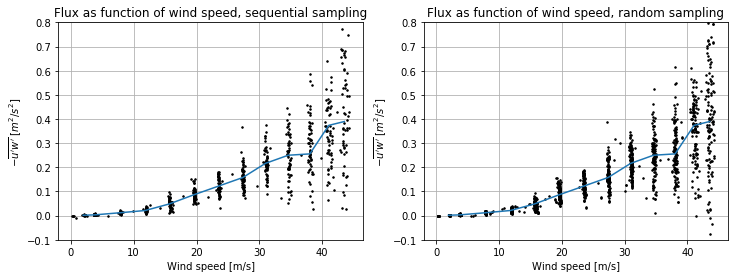

In [12]:
fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
axes = [ax1, ax2]

ax1.plot(U_seq, uw_seq, 'k.', ms=3)
ax1.plot(np.mean(U, 1), np.median(uw, 1), label='Median')
ax1.set_title('Flux as function of wind speed, sequential sampling')

ax2.plot(U, uw, 'k.', ms=3)
ax2.plot(np.mean(U, 1), np.median(uw, 1), label='Median')
ax2.set_title('Flux as function of wind speed, random sampling')

for ax in axes:
    ax.grid()
    ax.set_ylim(-0.1, 0.8)
    ax.set_xlabel('Wind speed [m/s]')
    ax.set_ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")

#### Let's compare them one on top of another

Text(0.5, 1.0, 'Flux as function of wind speed, comparison')

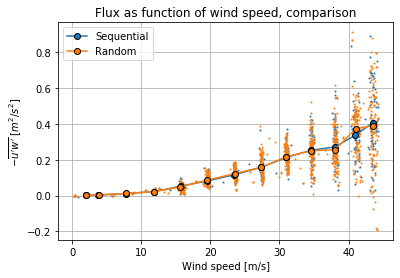

In [13]:
plt.plot(U_seq, uw_seq, marker='.', linestyle='', ms=2, color='tab:blue')
plt.plot(U, uw, marker='.', linestyle='', ms=2, color='tab:orange')
plt.plot(np.nanmean(U_seq, 1), np.nanmedian(uw_seq, 1), label='Sequential', color='tab:blue', marker='o', mec='k')
plt.plot(np.nanmean(U, 1), np.nanmedian(uw, 1), label='Random', color='tab:orange', marker='o', mec='k')
plt.legend()
plt.grid()
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")
plt.title('Flux as function of wind speed, comparison')

In [14]:
def normalize(x):
    """Normalize array x to (0, 1) (exclusive) range."""
    xnorm = (x - np.min(x)) / (np.max(x) - np.min(x))
    xnorm[xnorm < 1e-6] = 1e-6
    xnorm[xnorm > 1 - 1e-6] = 1 - 1e-6
    return xnorm


def moments_fit(x):
    """Fitting a Beta distribution using a moments approach."""
    xmean = np.mean(x)
    xvar = np.var(x)
    alpha = xmean * (xmean * (1 - xmean) - xvar) / xvar
    beta = (xmean - 1) * (xmean * (xmean - 1) + xvar) / xvar
    return alpha, beta


def beta_pdf(x, fitting_type='mle', floc=0, fscale=1):
    """Returns alpha and beta parameters from a beta distribution."""
    num_runs = x.shape[0]
    aa = np.zeros((num_runs))
    bb = np.zeros((num_runs))
    for n in range(num_runs):
        xnorm = normalize(x[n,:][~np.isnan(x[n,:])])
        if fitting_type == 'mle':
            aa[n], bb[n], loc, scale = beta.fit(xnorm, floc=floc, fscale=fscale)
        elif fitting_type == 'moments':
            aa[n], bb[n] = moments_fit(xnorm)
        else:
            raise ValueError('fitting_type not supported')
    return aa, bb


def dist_ks(x, alpha, beta):
    """Kolmogorov-Smirnoff distance. Not used yet."""
    x_sorted = np.sort(x)
    cdf = beta.cdf(x, alpha, beta)
    xx = np.linspace(1 / x.size, 1, x.size)
    series1 = np.abs(cdf - xx)
    series2 = np.abs(cdf - xx + 1 / x.size)
    return np.max(np.max(series1), np.max(series2))

## Stress distributions

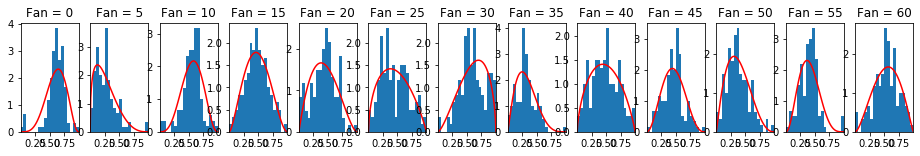

In [15]:
aa, bb = beta_pdf(uw, 'moments')

fig = plt.figure(figsize=(16, 2))
for n in range(len(fan)):
    ax = plt.subplot2grid((1, len(fan)), (0, n))
    data = normalize(uw[n,:][~np.isnan(uw[n,:])])
    plt.hist(data, 20, density=True)
    x = np.linspace(0, 1, 100)
    plt.plot(x, beta.pdf(x, aa[n], bb[n]), 'r-')
    plt.xlim(np.min(data), np.max(data))
    plt.title('Fan = ' + str(fan[n]))

Text(0, 0.5, "$-\\overline{u'w'}$ [$m^2/s^2$]")

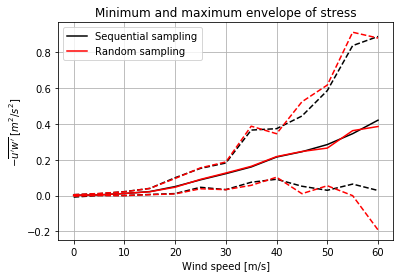

In [16]:
plt.plot(fan, np.min(uw_seq, axis=1), 'k--')
plt.plot(fan, np.max(uw_seq, axis=1), 'k--')
plt.plot(fan, np.mean(uw_seq, axis=1), 'k-', label='Sequential sampling')
plt.plot(fan, np.min(uw, axis=1), 'r--')
plt.plot(fan, np.max(uw, axis=1), 'r--')
plt.plot(fan, np.mean(uw, axis=1), 'r-', label='Random sampling')
plt.legend()
plt.grid()
plt.title('Minimum and maximum envelope of stress')
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")

## Processing waves from UDM

In [17]:
def elevation_from_udm(x):
    """Remove spikes and offset."""
    xx = x[:]
    for n in range(5):
        for i in range(1, xx.size-1):
            if xx[i] > 1.6:
                xx[i] = 0.5 * (xx[i-1] + xx[i+1])
    offset = np.mean(xx[:1200])
    xx = offset - xx
    return xx

In [18]:
# data parameters
files = glob.glob(DATAPATH + '/TOA5_SUSTAIN_ELEVx6_20Hz*.dat')

In [19]:
# read UDM data from TOA5 files
udm_time, u1, u2, u3, u4, u5, u6 = read_udm_from_toa5(files)

Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1275_2019_11_21_1600.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1276_2019_11_21_1700.dat
Reading  TOA5_SUSTAIN_ELEVx6_20Hz.ELEV_1277_2019_11_21_1800.dat


In [20]:
u3

array([0.9996481, 1.000238 , 1.000508 , ..., 1.152561 , 1.151715 ,
       1.151808 ])

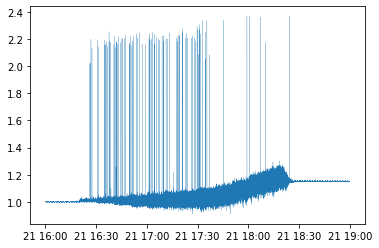

In [21]:
plt.plot(udm_time, u3, lw=0.2)

In [22]:
# map UDM arrays to sequential positions in the tank
udm = np.zeros((5, u1.size))
udm[0,:] = u6[:]
udm[1,:] = u5[:]
udm[2,:] = u1[:]
udm[3,:] = u3[:]
udm[4,:] = u4[:]

udm_fetch = fetch['udm']

In [23]:
udm_fetch

array([ 3.34,  7.08,  9.87, 11.94, 14.9 ])

In [24]:
# 10-minute time windows for each run; 
t0 = [start_time + timedelta(seconds=n * run_seconds)
    for n in range(len(fan))]
t1 = [start_time + timedelta(seconds=(n + 1) * run_seconds)
    for n in range(len(fan))]

Computing wave spectra for fan speed  5 Hz
Computing wave spectra for fan speed  10 Hz
Computing wave spectra for fan speed  15 Hz
Computing wave spectra for fan speed  20 Hz
Computing wave spectra for fan speed  25 Hz
Computing wave spectra for fan speed  30 Hz
Computing wave spectra for fan speed  35 Hz
Computing wave spectra for fan speed  40 Hz
Computing wave spectra for fan speed  45 Hz
Computing wave spectra for fan speed  50 Hz
Computing wave spectra for fan speed  55 Hz
Computing wave spectra for fan speed  60 Hz


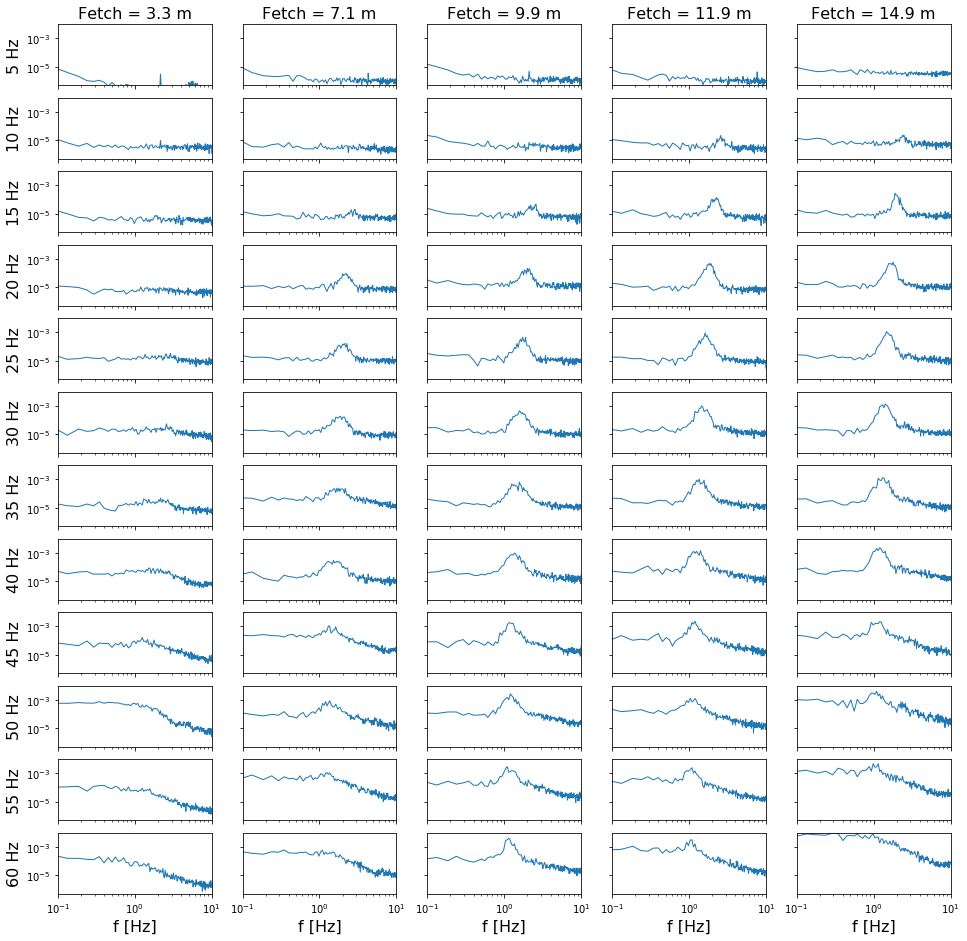

In [25]:
fig = plt.figure(figsize=(16, 16))
for n in range(1, len(fan)):
    print('Computing wave spectra for fan speed ', fan[n], 'Hz')
    mask = (udm_time >= t0[n]) & (udm_time <= t1[n])
    for i in range(5):
        ax = plt.subplot2grid((12, 5), (n - 1, i))
        e = detrend(elevation_from_udm(udm[i,mask]))
        F, f, df = power_spectrum(e, 1 / 20, binsize=32)
        ax.loglog(f, F, lw=1)
        plt.xlim(1e-1, 1e1)
        plt.ylim(5e-7, 1e-2)
        if n == 1: plt.title('Fetch = %.1f m' % udm_fetch[i], fontsize=16)
        if n == 12: plt.xlabel('f [Hz]', fontsize=16)
        if n != 12: ax.set_xticklabels([])
        if i == 0: plt.ylabel(str(fan[n]) + ' Hz', fontsize=16)
        if i != 0: ax.set_yticklabels([])

In [26]:
E = np.zeros((num_runs, num_samples))
Ek = np.zeros((num_runs, num_samples))
mss = np.zeros((num_runs, num_samples))
Tm = np.zeros((num_runs, num_samples))
Tp = np.zeros((num_runs, num_samples))

for n in range(num_runs):
    print('Computing wave spectra for fan speed ', fan[n], 'Hz')
    for i in range(num_samples):
        t0 = start_time + timedelta(seconds=n * run_seconds + sampling[n,i])
        t1 = t0 + timedelta(seconds=sample_seconds)
        mask = (udm_time >= t0) & (udm_time < t1)
        e = detrend(elevation_from_udm(udm[1,mask]))
        F, f, df = power_spectrum(e, 1 / 20, binsize=1)
        k = w2k(f)[0]
        dk = diffc(k)
        Fk = F * df / dk
        E[n,i] = np.sum(F) * df
        Ek[n,i] = np.sum(Fk * dk)
        fmask = f >= 0.5
        mss[n,i] = np.sum(Fk[fmask] * k[fmask]**2 * dk[fmask])
        Tm[n,i] = np.sum(F[fmask]) / np.sum(F[fmask] * f[fmask])
        Tp[n,i] = np.sum(F[fmask]**4) / np.sum(F[fmask]**4 * f[fmask])

Computing wave spectra for fan speed  0 Hz
Computing wave spectra for fan speed  5 Hz
Computing wave spectra for fan speed  10 Hz
Computing wave spectra for fan speed  15 Hz
Computing wave spectra for fan speed  20 Hz
Computing wave spectra for fan speed  25 Hz
Computing wave spectra for fan speed  30 Hz
Computing wave spectra for fan speed  35 Hz
Computing wave spectra for fan speed  40 Hz
Computing wave spectra for fan speed  45 Hz
Computing wave spectra for fan speed  50 Hz
Computing wave spectra for fan speed  55 Hz
Computing wave spectra for fan speed  60 Hz


Text(0.5, 1.0, 'Total wave energy [$m^2$]')

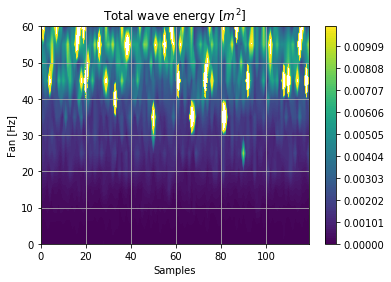

In [27]:
plt.contourf(range(num_samples), fan, E, np.linspace(0, 0.01, 100))
plt.colorbar()
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Fan [Hz]')
plt.title('Total wave energy [$m^2$]')

Text(0.5, 1.0, 'Mean period [s]')

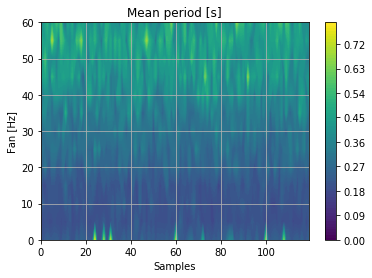

In [28]:
plt.contourf(range(num_samples), fan, Tm, np.arange(0, 0.81, 0.01))
plt.colorbar()
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Fan [Hz]')
plt.title('Mean period [s]')

Text(0.5, 1.0, 'Peak period [s]')

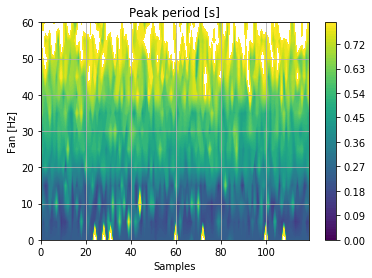

In [29]:
plt.contourf(range(num_samples), fan, Tp, np.arange(0, 0.81, 0.01))
plt.colorbar()
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Fan [Hz]')
plt.title('Peak period [s]')

Text(0.5, 1.0, 'Total wave energy [$m^2$]')

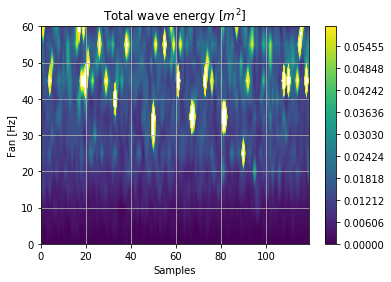

In [30]:
plt.contourf(range(num_samples), fan, mss, np.linspace(0, 0.06, 100))
plt.colorbar()
plt.grid()
plt.xlabel('Samples')
plt.ylabel('Fan [Hz]')
plt.title('Total wave energy [$m^2$]')

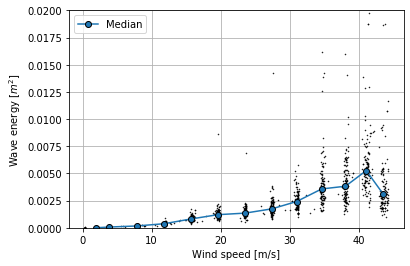

In [31]:
plt.plot(U, E, 'k.', ms=1)
plt.plot(np.nanmean(U, 1), np.nanmedian(E, 1), marker='o', mec='k', label='Median')
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r'Wave energy [$m^2$]')
plt.ylim(0, 0.02)
plt.grid()
plt.legend()

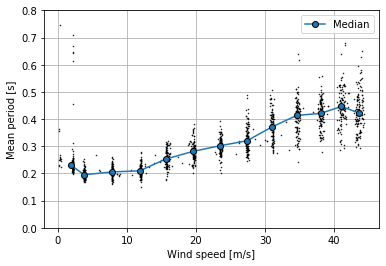

In [32]:
plt.plot(U, Tm, 'k.', ms=1)
plt.plot(np.nanmean(U, 1), np.nanmedian(Tm, 1), marker='o', mec='k', label='Median')
plt.legend()
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Mean period [s]')
plt.ylim(0, 0.8)
plt.grid()

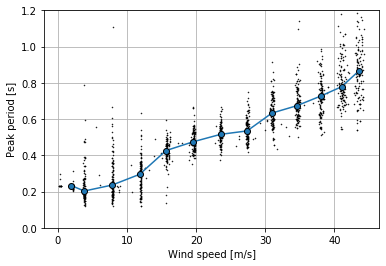

In [33]:
plt.plot(U, Tp, 'k.', ms=1)
plt.plot(np.nanmean(U, 1), np.nanmedian(Tp, 1), marker='o', mec='k', label='Median')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Peak period [s]')
plt.ylim(0, 1.2)
plt.grid()

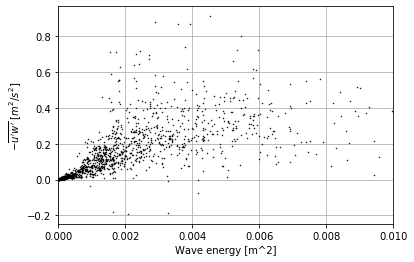

In [34]:
plt.plot(E, uw, 'k.', ms=1)
plt.xlim(0, 0.01)
plt.xlabel(r'Wave energy [m^2]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")
plt.grid()

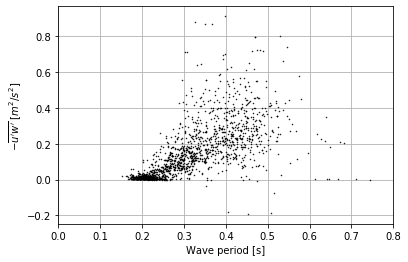

In [35]:
plt.plot(Tm, uw, 'k.', ms=1)
plt.xlabel(r'Wave period [s]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")
plt.xlim(0, 0.8)
plt.grid()

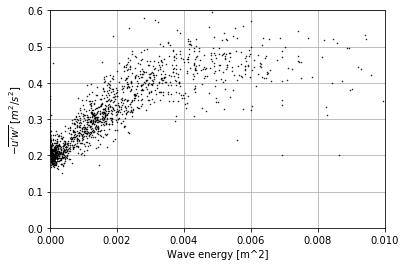

In [36]:
plt.plot(E, Tm, 'k.', ms=1)
plt.xlim(0, 0.01)
plt.ylim(0, 0.6)
plt.xlabel(r'Wave energy [m^2]')
plt.ylabel(r"$-\overline{u'w'}$ [$m^2/s^2$]")
plt.grid()

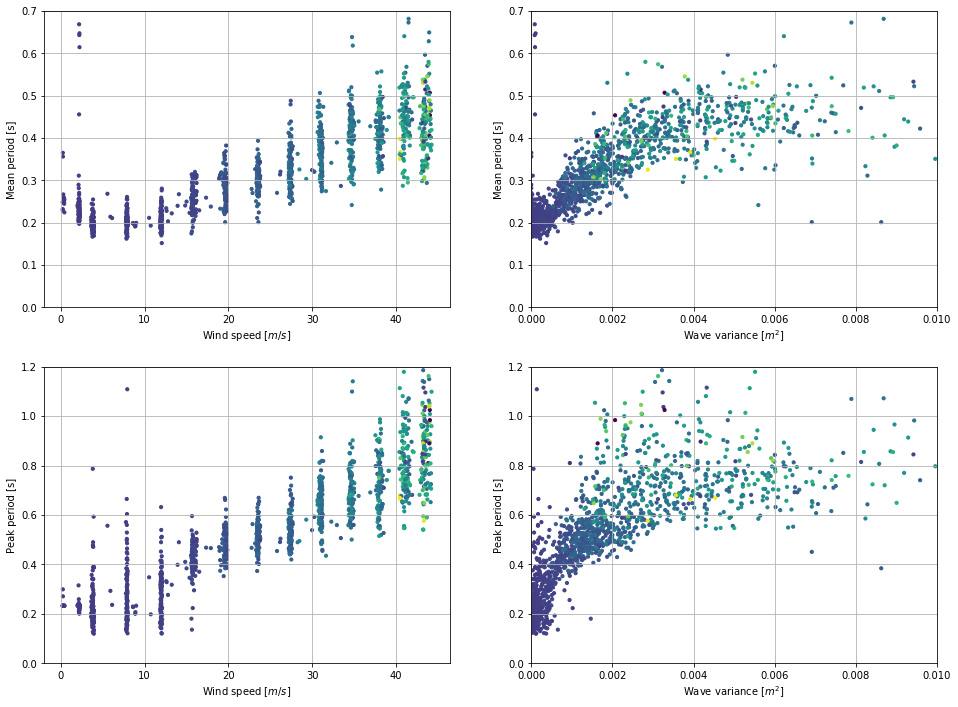

In [37]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))
axes = [ax1, ax2, ax3, ax4]

ax1.scatter(U, Tm, c=uw, s=10)
ax2.scatter(E, Tm, c=uw, s=10)
ax3.scatter(U, Tp, c=uw, s=10)
ax4.scatter(E, Tp, c=uw, s=10)
    
for ax in [ax1, ax3]:
    ax.set_xlabel('Wind speed [$m/s$]')
    
for ax in [ax2, ax4]:
    ax.set_xlim(0, 0.01)
    ax.set_xlabel('Wave variance [$m^2$]')
  
for ax in [ax1, ax2]:
    ax.set_ylim(0, 0.7)
    ax.set_ylabel('Mean period [s]')
      
for ax in [ax3, ax4]:
    ax.set_ylim(0, 1.2)
    ax.set_ylabel('Peak period [s]')
    
for ax in axes:
    ax.grid()